# Image Segmentation with watershed using Python

Imagine you need to segment some objects in an image, how to do that? In this
post I will show you how to use a classic segmentation technique called
watershed to do this.

## What is watershed segmentation?

Watershed segmentantion is one of the most popular algorithm for image
segmentation, normally used when we want to resolve one of the most difficult
operations in image processing - separating similar objects in the image that
are touching each other. For us to understand it easily, think of a grayscale
image as a topographic surface, and in this image high-intensity pixel values
represent peaks (white areas), whereas low-intensity values represent valleys -
local minima (black areas).

So imagine now that we start filling the whole valley with water, and after a
while the water coming up from different valleys will start to merge. To avoid
this, we need to build barriers at the places where the water would merge, so
the barriers are called basin lines and are used to determine the boundaries of
the segment. When the water filling fills from the highest peak we stop the
water filling. At the end of the process, only the watershed lines will be
visible and this will be the final result of the segmentation. Thus, the purpose
of the watershed is to identify watershed lines and segmented image.


![figure](https://miro.medium.com/max/1100/1*tM9ax1QPkaaa97c1aC_BJw.png)

https://www.rcet.org.in/uploads/academics/rohini_54591331912.pdf

In essence, we partition the image into two different sets:

* catchment basins- dark areas; The group of connected pixels with the same local minimum.

* watershed lines- Lines that divide one catchment area from another .

![figure](https://miro.medium.com/max/1400/1*lLYr7dhIkY-wtGC2FqRHCA.png)

Edited by https://media5.datahacker.rs/2020/10/7-2-1024x824.jpg

So, what’s the watershed algorithm pipeline?

    1. Binary image

    2. Calculate a distance transform

    3. Find local maxima points

    4. Label the marks

I Think it would be easier to show this pipeline together with Python’s code. First, let’s import the necessary libraries and do the image pre-processing.

In [9]:
%pip install --upgrade pip
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt

img = cv2.imread('images/coins.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
filtro = cv2.pyrMeanShiftFiltering(img, 20, 40)
gray = cv2.cvtColor(filtro, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

Let’s fill all hole that can be small (area is less than 1000 pixels).

In [11]:
contornos, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
buracos = []
for con in contornos:
  area = cv2.contourArea(con)
  if area < 1000:
    buracos.append(con)
cv2.drawContours(thresh, buracos, -1, 255, -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

We now need to try to separate the touching objects and try to create a border
betweeb them. One idea is to create a border as far as possible from the centers
of the overlapping objects. Then, weâ€™ll use a thecnique called distance
transform. It is an operator that generally takes binary images as inputs and
pixel intensities of the points inside the foreground regions are replaced by
their distance to the nearest pixel with zero intensity (background pixel). We
can use the fucntion distance_transform_edt() from scipy library. This fucntion
calculate the exact Euclidean distance transform.

In [12]:
dist = ndi.distance_transform_edt(thresh)
dist_visual = dist.copy()

If we plot the original image, binary image and the distance transform weâ€™ll see this image below.

Notes that in the distance transform we can see white pixels closets to the center, these pixels are larger distance transform value.

Now we need to find the coordinates of the peaks (local maxima) of the white
areas in the image. For that, we will use the function peak_local_max()from the
Scikit-image library. We will apply this function to our distance_transform
image and the output will give us the markers which will be used in the
watershed function.

In [13]:
local_max = peak_local_max(dist, indices=False, min_distance=20, labels=thresh)

/tmp/ipykernel_34062/1469441586.py:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(dist, indices=False, min_distance=20, labels=thresh)


Let's continue with our code. The next step is to label markers for the
watershed function. For that, we will use the function ndi.label()from the SciPy
library. This function consists of one parameter input which is an array-like
object to be labeled. Any non-zero values in this parameter are considered as
features and zero values are considered to be the background. In our code, we
will use the coordinates of the calculated local maximum. Then, the function
ndi.label()will randomly label all local maximums with different positive values
starting from 1. So, in case we have 10 objects in the image each of them will
be labeled with a value from 1 to 10.

In [14]:
markers = ndi.label(local_max, structure=np.ones((3, 3)))[0]

The final step is to apply the skimage.segmentation.watershed()function from the
Scikit-image library. As parameters, we need to pass our inverted distance
transform image and the markers that we calculated in the previous line of code.
Since the watershed algorithm assumes our markers represent local minima we need
to invert our distance transform image. In that way, light pixels will represent
high elevations, while dark pixels will represent the low elevations for the
watershed transform.

In [15]:
labels = watershed(-dist, markers, mask=thresh)

And finally, we will plot our original image, binary Image, distance transform image, and the watershed image.

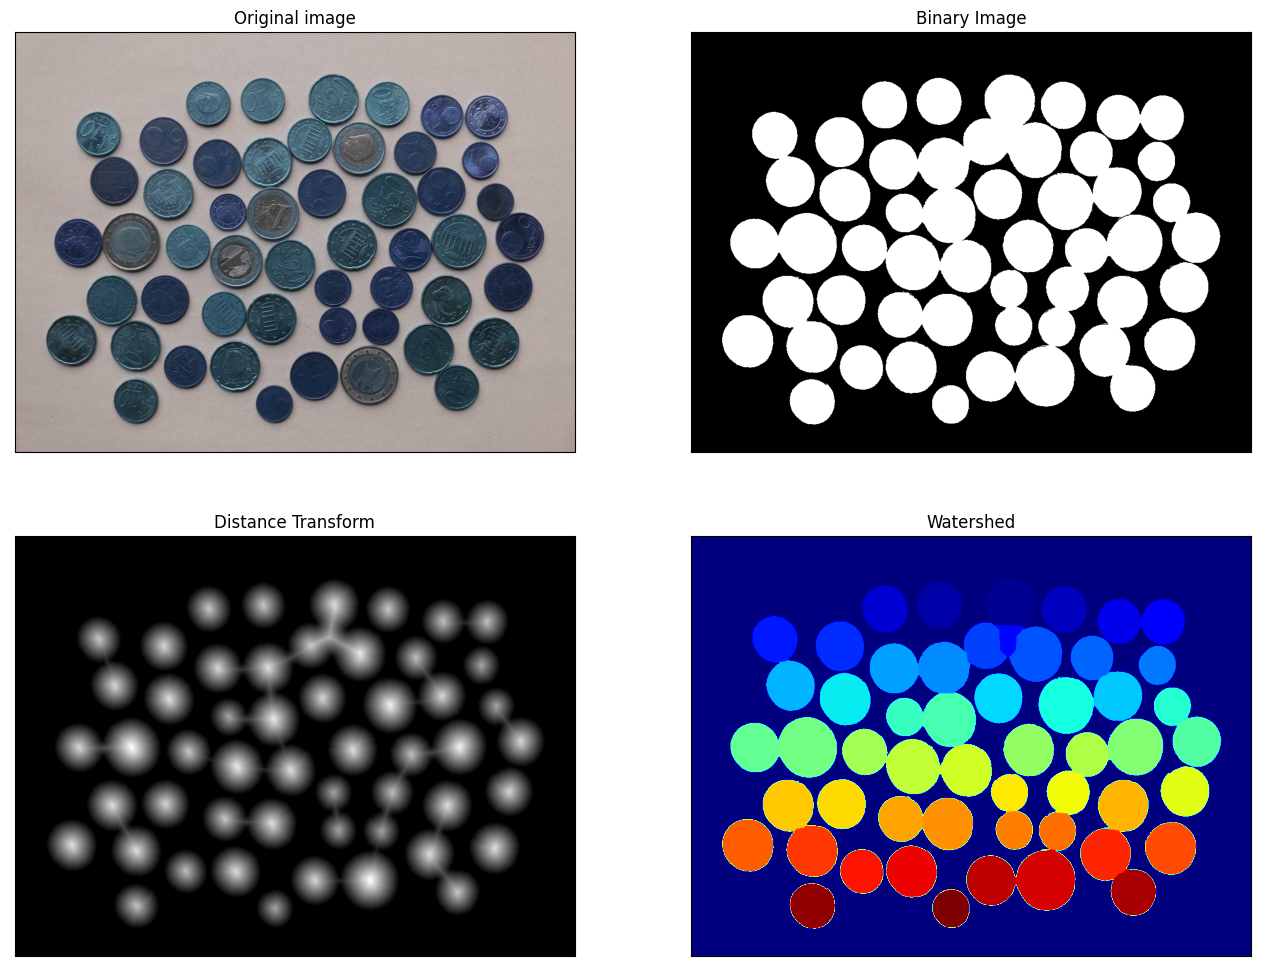

In [17]:
titulos = ['Original image', 'Binary Image', 'Distance Transform', 'Watershed']
imagens = [img, thresh, dist_visual, labels]
fig = plt.gcf()
fig.set_size_inches(16, 12)  
for i in range(4):
    plt.subplot(2,2,i+1)
    if (i == 3):
      cmap = "jet"
    else:
       cmap = "gray"
    plt.imshow(imagens[i], cmap)
    plt.title(titulos[i]) 
    plt.xticks([]),plt.yticks([])     
plt.show()

